<a href="https://colab.research.google.com/github/gmazzitelli/studenti/blob/master/simulate_imege.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import numpy as np   
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy.stats import chisquare
import scipy.stats as stats
from sklearn.datasets import make_blobs

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
plt.rc('font', size = 14, family ='Sans-Serif')

In [0]:
def confidence_ellipse_par(x, y):
    import numpy as np
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)

    if np.sqrt(cov[0, 0] * cov[1, 1]) == 0:
        width = height = -1
        pearson = np.nan
    else:
        pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
        # Using a special case to obtain the eigenvalues of this
        # two-dimensionl dataset.

        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        width=ell_radius_x * 2
        height=ell_radius_y * 2
    return width, height, pearson

def cluster_par(xc, yc, image):
    ph = 0.
    dim = xc.shape[0]
    for j in range(0, dim):
        x = int(xc[j])
        y = int(yc[j])
        ph += (image[y,x])
    return ph, dim

def Gauss3(x, a0, x0, s0):
    import numpy as np
    return a0 * np.exp(-(x - x0)**2 / (2 * s0**2))
    
def histGaus(var, bins, ax, color='b', xrange=False, alpha=1, label=''):
  if xrange:
    ax.hist(var, bins=bins, label=label, color=color, range=(xrange[0], xrange[1]), alpha=alpha)
    y, bins_edge = np.histogram(var, bins=bins, range=(xrange[0], xrange[1]))
  else:
    ax.hist(var, bins=bins, label=label, color=color)
    y, bins_edge = np.histogram(var, bins=bins)
  p0=[y.max(),bins_edge[y.argmax()], var.std()]
  x = np.linspace(bins_edge[0], bins_edge[-1], bins)
  popt, pcov = curve_fit(Gauss3, x, y, p0=p0)
  perr = np.sqrt(np.diag(pcov))
  r2=r2_score(y, Gauss3(x, *popt))
  x = np.linspace(bins_edge[0], bins_edge[-1], 100)
  sstat='a = {0:.2f} +/- {1:.2f}\nb = {2:.2f} +/- {3:.2f} \
  \nc = {4:.2f} +/- {5:.2f}\n$R^2$ = {6:.4f}'.format(popt[0], perr[0], popt[1], perr[1], 
                                                popt[2], perr[2], r2)
  ax.plot(x,Gauss3(x, *popt), color+'--', label=sstat)
  return ax

# genera imagine

Event:  0


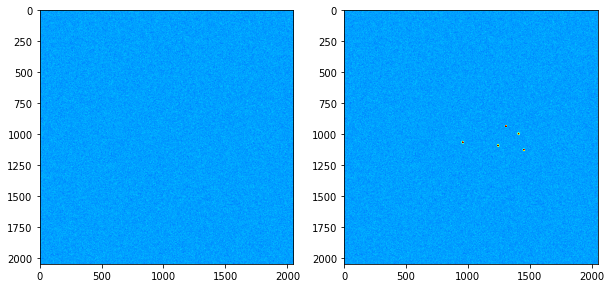

Event:  10


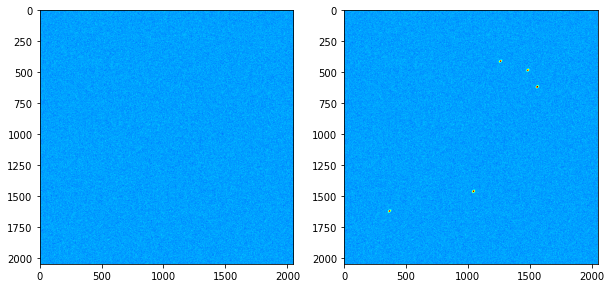

Event:  20


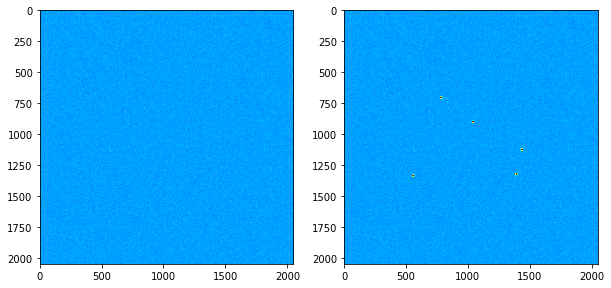

Event:  30


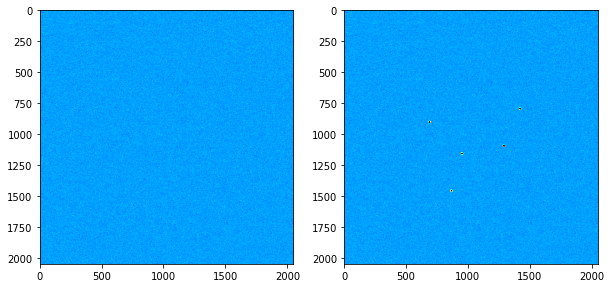

Event:  40


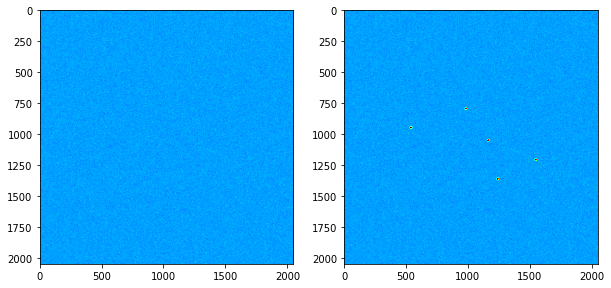

Event:  50


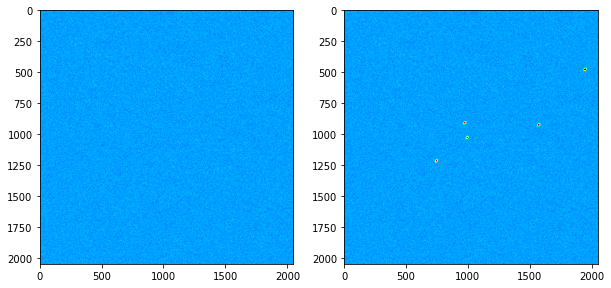

Event:  60


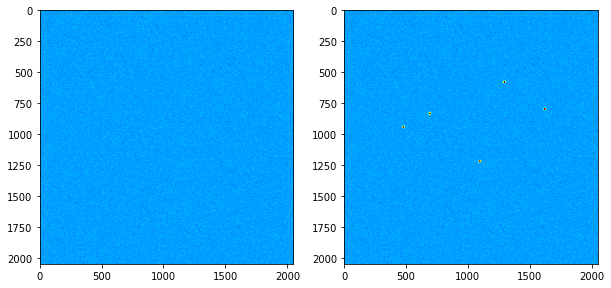

Event:  70


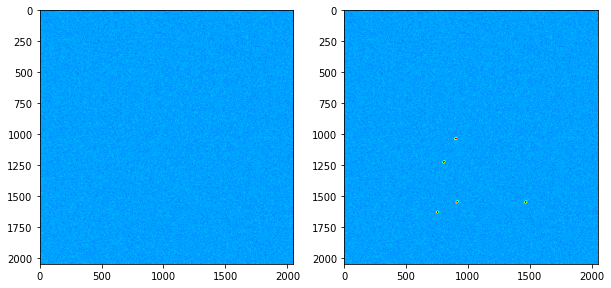

Event:  80


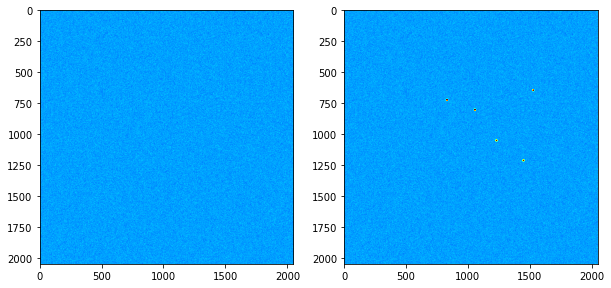

Event:  90


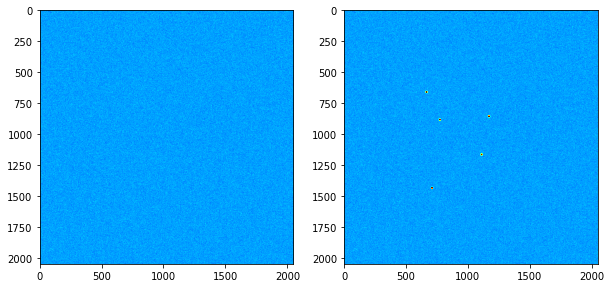

In [93]:
x_resolution = y_resolution = 2048
doplot=False


m_image       = 99.5
s_imege       = 3.8
xy_sigma      = 4.0
generazioni   = 100
di = pd.DataFrame(columns = ["iTr", "image"])
ds = pd.DataFrame(columns = ["iTr", "photons"])
for iTr in range(generazioni):

  noise = np.random.rand(x_resolution,y_resolution)*s_imege + m_image
  sim_imege = np.copy(noise)
  #
  photons = 3000 # definisce i fotoni per spot (per ora fissa andrebbe fata fluttuare con una gaussiana - polya)
  spot    = 5    # numero di spot nell'imagine anche questi andrebbeo genrati con una distribuzione dischreta attorno ad un certo valore
  #
  # n_features   = 3 crea un blob tridimesionale in un box center_box=(0, x_resolution)
  # random_state = seed per la simulazone 
  # 
  border = 500
  blobs_points, blobs_labels = make_blobs(n_samples=photons*spot, centers=spot, cluster_std = [xy_sigma,xy_sigma,xy_sigma,xy_sigma,xy_sigma],  
                                          n_features=3, random_state=iTr, center_box=(border, x_resolution-border))
  #
  d = np.random.uniform(low=-0.3, high=.3, size=1)
  transformation = [[1/(1-d), -d, 0 ], [-d, 1/(1-d), 0], [0, 0, 1]]
  blobs_points = np.dot(blobs_points, transformation)
  for k in range(spot):
    intensity = blobs_points[:, 2][blobs_labels==k]
    blobs_points[:, 2][blobs_labels==k]=(intensity-intensity.mean())/intensity.std()
    # si puo' solo sommare mai sottrarre al rumore
    blobs_points[:, 2][blobs_labels==k]=blobs_points[:, 2][blobs_labels==k]+abs(blobs_points[:, 2][blobs_labels==k].min())
    ph = blobs_points[:, 2][blobs_labels==k].sum()/xy_sigma # patch messa per la generazine perche' make blobs genera con 
                                                            # della sigma fisse (o va scoperto come si fa)
    ds = ds.append({"iTr":iTr, "blobs_points":k, "photons":ph}, ignore_index=True)

  for j in range(len(blobs_points)):
    x = int(blobs_points[j][0])
    y = int(blobs_points[j][1])
    z = int(blobs_points[j][2])/xy_sigma # patch messa per la generazine perche' make blobs genera con 
                                         # della sigma fisse (o va scoperto come si fa)
    sim_imege[x,y] += z
    # print(x,y,z, noise[x,y],  sim_imege[x,y])
    

  #ax[1].scatter(blobs_points[:, 1], blobs_points[:, 0], c=blobs_labels)
  
  if doplot or iTr % 10 == 0:
    print ('Event: ', iTr)
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].imshow(noise, cmap="jet" , vmin=98,vmax=110)
    ax[1].imshow(sim_imege, cmap="jet" , vmin=98,vmax=110)
    plt.show()
  di = di.append({"iTr":iTr, "image":sim_imege}, ignore_index=True)

In [89]:
y

367

In [77]:
ds.tail()

,iTr,photons,blobs_points
495,99.0,2452.577832,0.0
496,99.0,2604.912876,1.0
497,99.0,2660.719968,2.0
498,99.0,2529.341997,3.0
499,99.0,2724.850270,4.0


In [78]:
di.tail()

,iTr,image
95,95,"[[103.10788429168959, 100.6815353246134, 102.7..."
96,96,"[[102.46209246321627, 100.01657847316011, 99.8..."
97,97,"[[103.08442359970012, 100.60085216335966, 101...."
98,98,"[[102.67134228509151, 100.72536044441641, 100...."
99,99,"[[100.4115443148208, 101.47887197846642, 101.6..."


# trova cluster nella imagine

In [0]:
df = pd.DataFrame(columns = ["iTr", "cluster_lable", "pixels", "photons", "ph_pixels", "x0start", "y0start", 
          "x0end", "y0end", "width", "height", "pearson"])
nsigma = 3.5
s_imege = noise.std()
th = s_imege*nsigma
for iTr in range(len(di)):
  sim_imege       = np.array(di.image[iTr])
  edges           = (sim_imege-m_image > th)       
  points          = np.array(np.nonzero(edges)).T.astype(float) 
  X_scaled        = StandardScaler().fit_transform(points)
  # noramalizza le futures
  dbscan          = DBSCAN(eps=0.2, min_samples = 30).fit(X_scaled)
  # 
  labels = dbscan.labels_
  for ic in range (min(dbscan.labels_), max(dbscan.labels_)+1):
    ph = 0.
    yc = points[:,1][dbscan.labels_==ic]
    xc = points[:,0][dbscan.labels_==ic]
    ph, dim = cluster_par(yc, xc, sim_imege-m_image)
    width, height, pearson = confidence_ellipse_par(yc,xc)
    for j in range(0, dim):
        x=int(xc[j])
        y=int(yc[j])
        if j == 0:
            x0start = x
            y0start = y
    x0end = x
    y0end = y
    df = df.append({"iTr":iTr, "cluster_lable":ic, "pixels":dim, "photons":ph, "ph_pixels":ph/dim, "x0start":x0start, "y0start":y0start, 
      "x0end":x0end, "y0end":y0end, "width":width, "height":height, "pearson":pearson},
                    ignore_index=True)
df['length'] = np.sqrt((df['x0end'] - df['x0start'])**2 + (df['y0end'] - df['y0start'])**2)
df['x0c'] = (df['x0end'] + df['x0start'])/2.
df['y0c'] = (df['y0end'] + df['y0start'])/2.

In [80]:
df.tail()

,iTr,cluster_lable,pixels,photons,ph_pixels,x0start,y0start,x0end,y0end,width,height,pearson,length,x0c,y0c
483,98.0,4.0,304.0,2470.292842,8.125963,1602.0,725.0,1630.0,723.0,1.682492,2.273592,-0.292305,28.071338,1616.0,724.0
484,99.0,0.0,572.0,5259.553360,9.195023,436.0,1384.0,491.0,1414.0,2.739124,0.705122,0.875701,62.649820,463.5,1399.0
485,99.0,1.0,301.0,2820.196330,9.369423,818.0,534.0,848.0,534.0,1.844448,2.144298,-0.149503,30.000000,833.0,534.0
486,99.0,2.0,291.0,2797.774822,9.614346,877.0,1033.0,903.0,1028.0,1.847831,2.141383,-0.146381,26.476405,890.0,1030.5
487,99.0,3.0,286.0,2528.070105,8.839406,1211.0,1002.0,1237.0,1004.0,1.828204,2.158164,-0.164418,26.076810,1224.0,1003.0


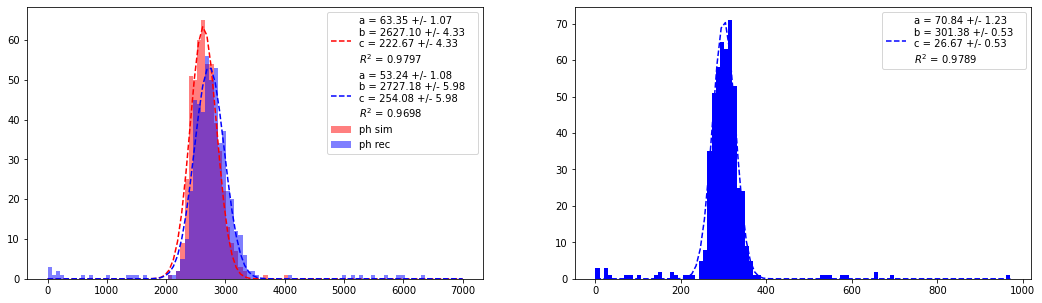

In [55]:
fig, ax = plt.subplots(1,2, figsize=(18,5))
#ax[0].hist(ds.photons, bins=100, label='ph sim', color='red', alpha=0.5, range=(0,7000))
histGaus(ds.photons, 100, ax[0], color='r', xrange=[0,7000], alpha=0.5, label='ph sim')
#ax[0].hist(df.photons[df.cluster_lable>-1], bins=100, label='ph rec', alpha=0.5, range=(0,7000))
histGaus(df.photons, 100, ax[0], color='b', xrange=[0,7000], alpha=0.5,label='ph rec')
#ax[1].hist(df.pixels[df.cluster_lable>-1], bins=100, label='pixels', alpha=0.5, range=(0,700))
histGaus(df.pixels, 100, ax[1])
ax[0].legend()
ax[1].legend()
plt.show()

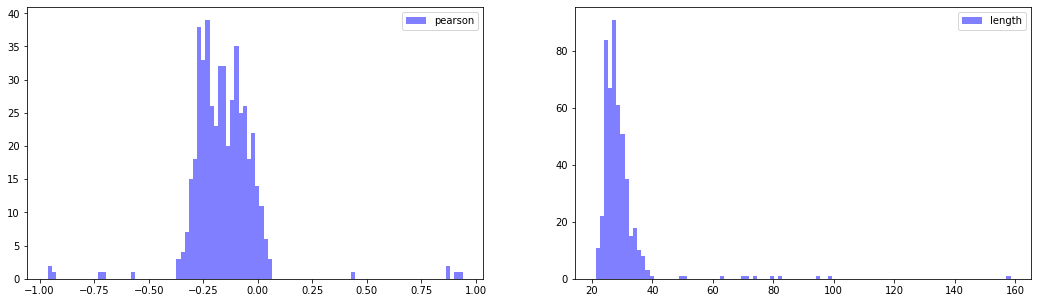

In [84]:
fig, ax = plt.subplots(1,2, figsize=(18,5))
ax[0].hist(df.pearson, bins=100, label='pearson', color='blue', alpha=0.5)
ax[1].hist(df.length, bins=100, label='length', color='blue', alpha=0.5)
ax[0].legend()
ax[1].legend()
plt.show()

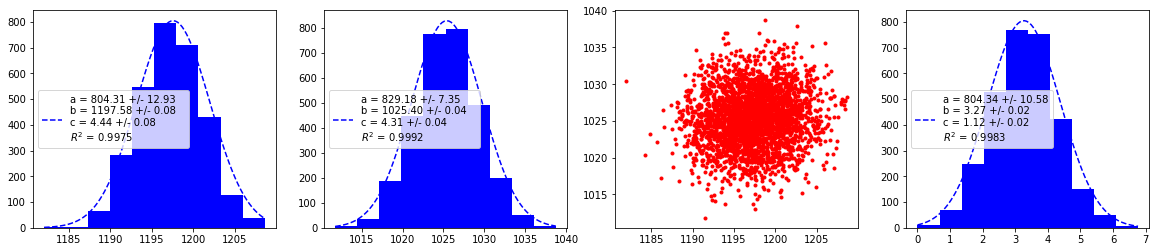

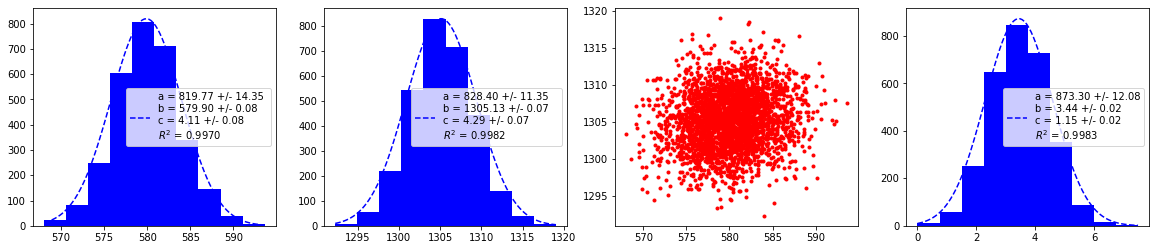

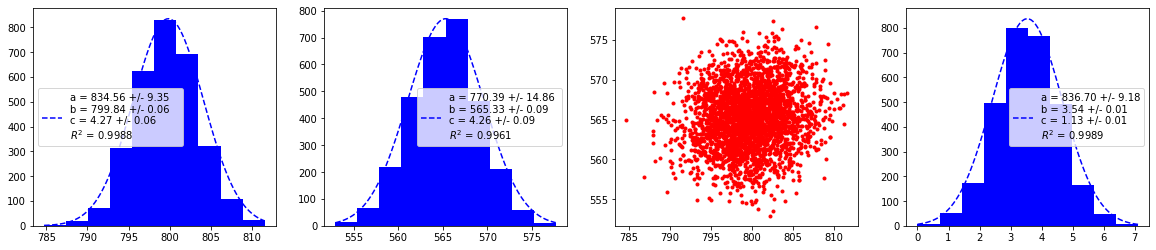

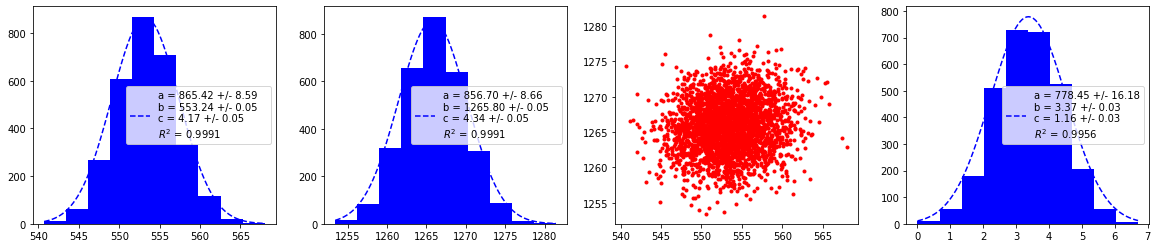

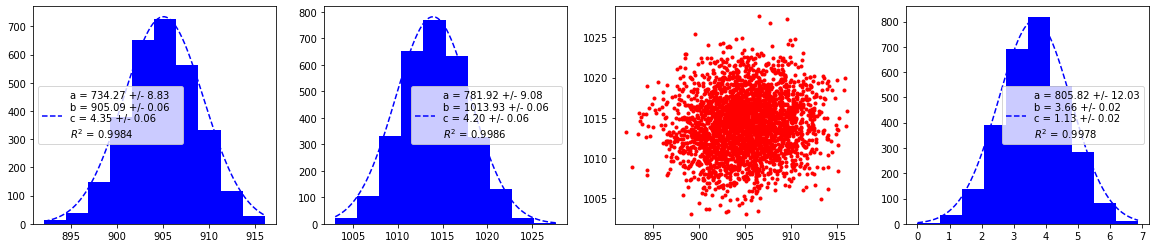

In [94]:
#
# controllo sulla e generazione del blob
#
nsigma = 1.5
th = s_imege*nsigma
for i in range(spot):
  fig, ax = plt.subplots(1,4, figsize=(20,4))
  bins=10
  var = blobs_points[:, 0][blobs_labels==i]
  histGaus(var, bins, ax[0])
  ax[0].legend()
  var = blobs_points[:, 1][blobs_labels==i]
  histGaus(var, bins, ax[1])
  #print (len(blobs_points[:, 2][blobs_labels==i]), p0)
  ax[1].legend()
  ax[2].plot(blobs_points[:,0][blobs_labels==i],blobs_points[:,1][blobs_labels==i], 'r.')
  # edges           = (sim_imege-m_image > th)       
  # points          = np.array(np.nonzero(edges)).T.astype(float) 
  # ax[2].plot(points[:,0],points[:,1], 'y.')
  var=blobs_points[:,2][blobs_labels==i]
  histGaus(var, 10, ax[3])
  ax[3].legend()
  plt.show()

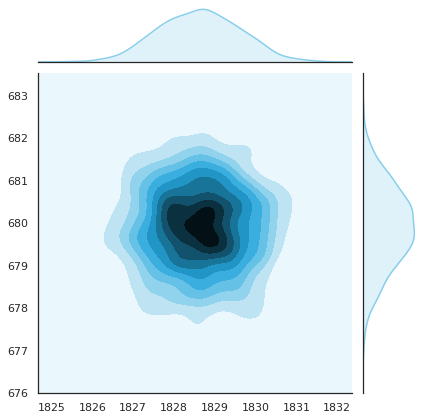

In [0]:
import seaborn as sns
sns.set(style="white", color_codes=True)
sns.jointplot(blobs_points[:,0][blobs_labels==l],blobs_points[:,1][blobs_labels==l], kind='kde', color="skyblue")
plt.show()

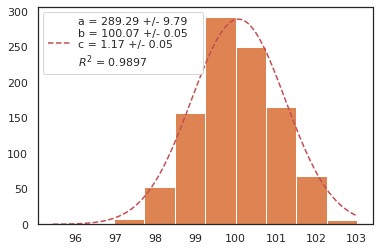

In [0]:
var = np.random.normal(100,1,1000)
fig,ax=plt.subplots(1)
ax.hist(var, 10)
histGaus(var, 10, ax=ax)
ax.legend()
plt.show()

In [0]:
noise = np.random.rand(x_resolution,y_resolution)*s_imege + m_image
edge = (noise > 101)

In [31]:
noise.max()-noise.min()

3.799999582340817

In [27]:
s_imege

3.8

In [30]:
noise.max()

103.29999986506598

In [6]:
noise.std()

1.096718609775755

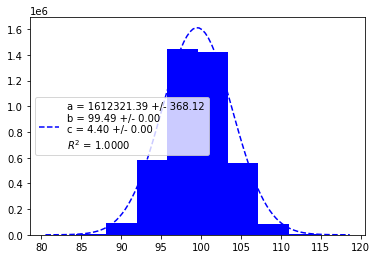

In [43]:
empty = np.ones((x_resolution,y_resolution), dtype=float)
var = np.random.normal(m_image,s_imege,x_resolution*y_resolution)
fig,ax=plt.subplots(1)
ax.hist(var, 10)
histGaus(var, 10, ax=ax)
ax.legend()
plt.show()

[[14.49125921  1.26301967]
 [ 1.26301967 14.53240249]]


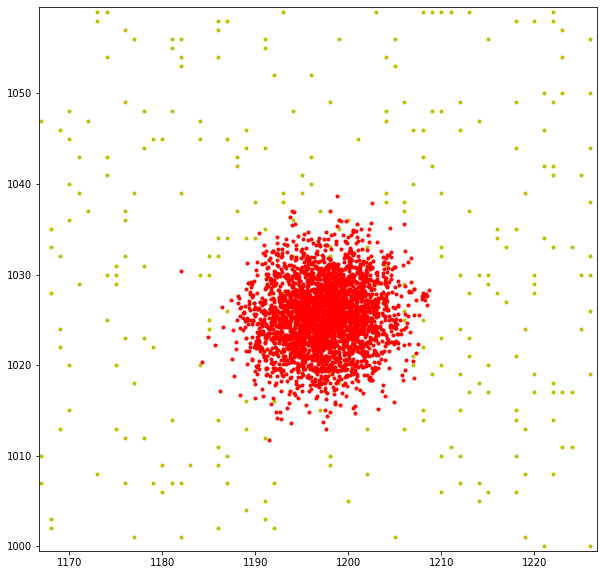

In [95]:
fig, ax = plt.subplots(1, figsize=(10,10))
noise.std()
i=0
edges           = (noise-m_image > 3.5) 
points          = np.array(np.nonzero(edges)).T.astype(float) 
plt.plot(points[:,0],points[:,1], 'y.')

x = blobs_points[:,0][blobs_labels==i]
y = blobs_points[:,1][blobs_labels==i]
plt.plot(x,y, 'r.')
ind = blobs_points[:,2][blobs_labels==i].argmax()
plt.ylim(y[ind]-30, y[ind]+30)
plt.xlim(x[ind]-30, x[ind]+30)
print(np.cov(x, y))
plt.show()

In [61]:
blobs_points[:,2][blobs_labels==i].argmax()

224

In [17]:
(sim_imege-m_image >noise.std()*3.5).sum()

1338

2.8873392427599542